In [1]:
import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt

from utils.functions import *

%load_ext autoreload
%autoreload 2

# 1. N=40, K=8, p=[0.1,0.2,0.3,0.4,0.5]

# 1.1 CodeBook Design

In [154]:
N   = 40
K   = 8
T_0 = 4

Codebook_Proposed = CodeBookDesign_Bin(N,K,T_0)
Codebook_Proposed_T2 = CodeBookDesign_Bin(N,K,2)

Codebook_Partition = CodeBookDesign_Partition(N,K)

# print(Codebook_Partition)

@CodeBookDesign_Bin, Codebook Size= 45
@CodeBookDesign_Bin, Codebook Size= 4845
@CodeBookDesign_Partition, Codebook Size= 5


# 1.2. Main Loop

In [35]:
p_array = np.array([0.1, 0.2, 0.3, 0.4, 0.5]) # dropout rate

# print(p_matrix)
p_sel = np.random.randint(low=0, high=len(p_array), size=(N,))

p_per_user = np.ones((N,))

for i in range(N):
    p_per_user[i] = p_array[p_sel[i]]

print(p_per_user)

print(np.random.binomial(1,0.2, size=1))

[0.5 0.2 0.2 0.5 0.5 0.1 0.5 0.5 0.2 0.1 0.2 0.3 0.5 0.3 0.3 0.2 0.3 0.3
 0.4 0.3 0.3 0.3 0.5 0.5 0.5 0.3 0.1 0.1 0.3 0.4 0.1 0.2 0.3 0.3 0.5 0.5
 0.5 0.1 0.2 0.1]
[0]


In [98]:
J = 100  # Total iterations

is_print = False
# is_print = False

is_print_tmp = True

is_selection_applied = True

N_schemes = 4

N_trial = 100

Agg_Card = np.zeros((N_schemes, N_trial, J))
Privacy  = np.zeros((N_schemes, N_trial, J))
Fairness = np.zeros((N_schemes, N_trial, J))


for trial_idx in range(N_trial):
    
    print('trial_idx=',trial_idx)
#     print()
    
    P_random    = []
    P_partition = []
    P_proposed  = []
    P_proposed_T2 = []
    
    for j in range(J):
        
        # Realization of u vector with the same dropout probability
#         u = np.random.binomial(1, 1-p, size=(N))
        
        u = np.ones((N,))
        for u_idx in range(N):
            p_sel = p_per_user[u_idx]
            u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
        
        if is_print:
            print('[iter=',j,'] Surviving vector u=',u)

        if np.sum(u) < K:
            p_tmp = np.zero(N)

            P_random.append(p_tmp)
            P_partition.append(p_tmp)
            P_proposed.append(p_tmp)
            P_proposed_T2.append(p_tmp)
        else:
            result = np.where(u == 1)

            ###############################
            # 1. Random Selection
            ###############################
            select = np.random.choice(result[0], K, replace=False)

            p_tmp = np.zeros(N)
            p_tmp[select] = 1

            P_random.append(p_tmp)

            # 1.1 Calculate Privacy
            P = np.array(P_random)
            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)

            if j == 0:
                Privacy[0,trial_idx,j] = partial_sum
            else:
                Privacy[0,trial_idx,j] = np.min([partial_sum, Privacy[0,trial_idx,j-1]])

            # 1.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_random),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[0,trial_idx,j] = acc_card/(j+1)
            
            
            # 1.3. Calculate Fairness
            P = np.array(P_random)
#             P_sum = np.sum(P, axis=0)/(j+1)
#             Fairness[0,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            num_aggr_true = acc_card / K

            if num_aggr_true == 0:
                Fairness[0,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[0,trial_idx,j] = np.max(P_sum) - np.min(P_sum)           
            


            if is_print:
                print('[iter=',j,'] @Random Method, Codebook selection')
                
            

            ###############################
            # 2. Partition
            ###############################

            tmp = Codebook_Partition * u
            codebook_en = 1*(np.sum(tmp,axis=1) == K)
    #         print(np.sum(tmp,axis=1))
    #         print(codebook_en)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',j,'] @Partition Method, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',j,'] @Partition Method, Codebook selection')
                idx_en = np.where(codebook_en == 1)
                
                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Partition[idx_en,:],(codebook_en_num,N))
                    
                    p_tmp = UserSelection_Codebook(P_partition, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Partition[idx_sel[0],:]
                    
#                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

#                 p_tmp = Codebook_Partition[idx_sel[0],:]

            P_partition.append(p_tmp)

            # 2.1 Calculate Privacy
            P = np.array(P_partition)
            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)
            if partial_sum == N+1:
                partial_sum = K

            if j == 0:
                Privacy[1,trial_idx,j] = partial_sum
            else:
                Privacy[1,trial_idx,j] = np.min([partial_sum, Privacy[1,trial_idx,j-1]])

            # 2.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_partition),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[1,trial_idx,j] = acc_card/(j+1)
            
            # 2.3. Calculate Fairness
            P = np.array(P_partition)
#             P_sum = np.sum(P, axis=0)/(j+1)
#             Fairness[1,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            num_aggr_true = acc_card / K
            
            if num_aggr_true == 0:
                Fairness[1,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[1,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            

            ###############################
            # 3. Proposed, T_0 = 4
            ###############################

            tmp = Codebook_Proposed * u
            codebook_en = 1*(np.sum(tmp,axis=1) == K)
    #         print(np.sum(tmp,axis=1))
    #         print(codebook_en)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',j,'] @Proposed Method, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',j,'] @Proposed Method, Codebook selection')
                idx_en = np.where(codebook_en == 1)
                
                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed[idx_en,:],(codebook_en_num,N))
                    
                    p_tmp = UserSelection_Codebook(P_proposed, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed[idx_sel[0],:]



            P_proposed.append(p_tmp)

            # 3.1 Calculate Privacy
            P = np.array(P_proposed)

            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)
            if partial_sum == N+1:
                partial_sum = K

            if j == 0:
                Privacy[2,trial_idx,j] = partial_sum
            else:
                Privacy[2,trial_idx,j] = np.min([partial_sum, Privacy[2,trial_idx,j-1]])

            # 3.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_proposed),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[2,trial_idx,j] = acc_card/(j+1)
            
            # 3.3. Calculate Fairness
            P = np.array(P_proposed)
#             P_sum = np.sum(P, axis=0)/(j+1)
#             Fairness[2,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            num_aggr_true = acc_card / K
            
            if num_aggr_true == 0:
                Fairness[2,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[2,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            
            
            ###############################
            # 4. Proposed, T_0 = 2
            ###############################

            tmp = Codebook_Proposed_T2 * u
            codebook_en = 1*(np.sum(tmp,axis=1) == K)
    #         print(np.sum(tmp,axis=1))
    #         print(codebook_en)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',j,'] @Proposed Method 2, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',j,'] @Proposed Method 2, Codebook selection')
                idx_en = np.where(codebook_en == 1)
                
                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed_T2[idx_en,:],(codebook_en_num,N))
                    
                    p_tmp = UserSelection_Codebook(P_proposed_T2, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed_T2[idx_sel[0],:]
                    

    #             print('idx_sel=',idx_sel)

                



            P_proposed_T2.append(p_tmp)

            # 4.1 Calculate Privacy
            P = np.array(P_proposed_T2)

            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)
            if partial_sum == N+1:
                partial_sum = K

            if j == 0:
                Privacy[3,trial_idx,j] = partial_sum
            else:
                Privacy[3,trial_idx,j] = np.min([partial_sum, Privacy[3,trial_idx,j-1]])

            # 4.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_proposed_T2),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[3,trial_idx,j] = acc_card/(j+1)
            
            # 4.3. Calculate Fairness
            P = np.array(P_proposed_T2)
            
            num_aggr_true = acc_card / K
            
            if num_aggr_true == 0:
                Fairness[3,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[3,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            

            if is_print:
                print()


        # random selection

#     print(Privacy)
#     print()
#     print(Agg_Card)


mean_priavcy_pdiff = np.sum(Privacy, axis=1)/N_trial
print(np.shape(mean_priavcy_pdiff))

mean_Agg_Card_pdiff = np.sum(Agg_Card, axis=1)/N_trial
print(np.shape(mean_Agg_Card_pdiff))

mean_fairness_pdiff = np.sum(Fairness, axis=1)/N_trial
print(np.shape(mean_fairness_pdiff))

trial_idx= 0
trial_idx= 1
trial_idx= 2
trial_idx= 3
trial_idx= 4
trial_idx= 5
trial_idx= 6
trial_idx= 7
trial_idx= 8
trial_idx= 9
trial_idx= 10
trial_idx= 11
trial_idx= 12
trial_idx= 13
trial_idx= 14
trial_idx= 15
trial_idx= 16
trial_idx= 17
trial_idx= 18
trial_idx= 19
trial_idx= 20
trial_idx= 21
trial_idx= 22
trial_idx= 23
trial_idx= 24
trial_idx= 25
trial_idx= 26
trial_idx= 27
trial_idx= 28
trial_idx= 29
trial_idx= 30
trial_idx= 31
trial_idx= 32
trial_idx= 33
trial_idx= 34
trial_idx= 35
trial_idx= 36
trial_idx= 37
trial_idx= 38
trial_idx= 39
trial_idx= 40
trial_idx= 41
trial_idx= 42
trial_idx= 43
trial_idx= 44
trial_idx= 45
trial_idx= 46
trial_idx= 47
trial_idx= 48
trial_idx= 49
trial_idx= 50
trial_idx= 51
trial_idx= 52
trial_idx= 53
trial_idx= 54
trial_idx= 55
trial_idx= 56
trial_idx= 57
trial_idx= 58
trial_idx= 59
trial_idx= 60
trial_idx= 61
trial_idx= 62
trial_idx= 63
trial_idx= 64
trial_idx= 65
trial_idx= 66
trial_idx= 67
trial_idx= 68
trial_idx= 69
trial_idx= 70
trial_idx= 71
tr

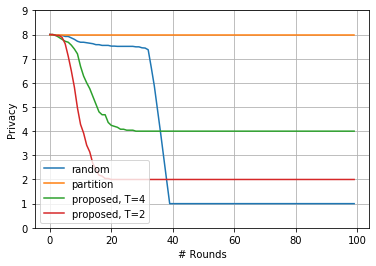

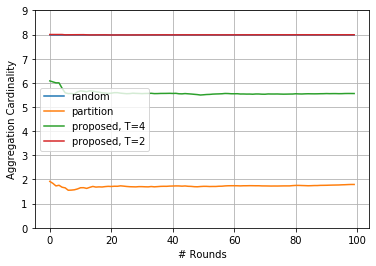

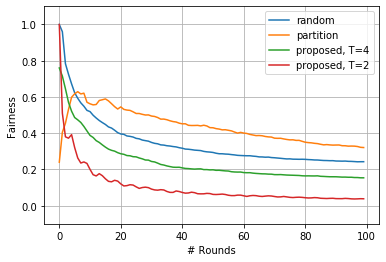

In [114]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

plt.plot(mean_priavcy_pdiff[0,:], label='random')
plt.plot(mean_priavcy_pdiff[1,:], label='partition')
plt.plot(mean_priavcy_pdiff[2,:], label='proposed, T=4')
plt.plot(mean_priavcy_pdiff[3,:], label='proposed, T=2')
plt.ylabel('Privacy')
plt.xlabel('# Rounds')
plt.ylim([0,9])
plt.grid()
plt.legend()
plt.show()

plt.plot(mean_Agg_Card_pdiff[0,:], label='random')
plt.plot(mean_Agg_Card_pdiff[1,:], label='partition')
plt.plot(mean_Agg_Card_pdiff[2,:], label='proposed, T=4')
plt.plot(mean_Agg_Card_pdiff[3,:], label='proposed, T=2')
plt.ylabel('Aggregation Cardinality')
plt.xlabel('# Rounds')
plt.ylim([0,9])
plt.grid()
plt.legend()
plt.show()

plt.plot(mean_fairness_pdiff[0,:], label='random')
plt.plot(mean_fairness_pdiff[1,:], label='partition')
plt.plot(mean_fairness_pdiff[2,:], label='proposed, T=4')
plt.plot(mean_fairness_pdiff[3,:], label='proposed, T=2')
plt.ylabel('Fairness')
plt.xlabel('# Rounds')
plt.ylim([-0.1,1.1])
plt.grid()
plt.legend()
plt.show()

In [77]:
def UserSelection_Codebook(P, B):
    CodeBook_size, N = np.shape(B)
#     print(CodeBook_size, N)
    
    P_sum = np.sum(P, axis=0)
#     print(P_sum)
    
    score = np.zeros((CodeBook_size,))
    for i in range(len(B)):
        tmp_code = B[i,:]
        score[i] = np.sum(P_sum * tmp_code)
#         print(tmp_score)
#     print(score)
    
    index_array = np.argmin(score)
    
#     print(index_array)
    
    return B[index_array,:]

print(np.shape(P_partition))
print(np.shape(Codebook_Partition))

UserSelection_Codebook(P_partition, Codebook_Partition)


(50, 40)
(5, 40)


array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [81]:
print(np.shape(codebook_en))
np.sum(codebook_en)

(4845,)


210

In [84]:
idx_en = np.where(codebook_en == 1)
print(np.shape(Codebook_Proposed_T2[idx_en,:]))
print(np.shape(Codebook_Proposed_T2))


(1, 210, 40)
(4845, 40)


In [111]:
J = 100  # Total iterations

is_print = False
# is_print = False

is_print_tmp = True

is_selection_applied = False

N_schemes = 4

N_trial = 100

Agg_Card = np.zeros((N_schemes, N_trial, J))
Privacy  = np.zeros((N_schemes, N_trial, J))
Fairness = np.zeros((N_schemes, N_trial, J))


for trial_idx in range(N_trial):
    
    print('trial_idx=',trial_idx)
#     print()
    
    P_random    = []
    P_partition = []
    P_proposed  = []
    P_proposed_T2 = []
    
    for j in range(J):
        
        # Realization of u vector with the same dropout probability
#         u = np.random.binomial(1, 1-p, size=(N))
        
        u = np.ones((N,))
        for u_idx in range(N):
            p_sel = p_per_user[u_idx]
            u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
        
        if is_print:
            print('[iter=',j,'] Surviving vector u=',u)

        if np.sum(u) < K:
            p_tmp = np.zero(N)

            P_random.append(p_tmp)
            P_partition.append(p_tmp)
            P_proposed.append(p_tmp)
            P_proposed_T2.append(p_tmp)
        else:
            result = np.where(u == 1)

            ###############################
            # 1. Random Selection
            ###############################
            select = np.random.choice(result[0], K, replace=False)

            p_tmp = np.zeros(N)
            p_tmp[select] = 1

            P_random.append(p_tmp)

            # 1.1 Calculate Privacy
            P = np.array(P_random)
            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)

            if j == 0:
                Privacy[0,trial_idx,j] = partial_sum
            else:
                Privacy[0,trial_idx,j] = np.min([partial_sum, Privacy[0,trial_idx,j-1]])

            # 1.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_random),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[0,trial_idx,j] = acc_card/(j+1)
            
            
            # 1.3. Calculate Fairness
            P = np.array(P_random)
#             P_sum = np.sum(P, axis=0)/(j+1)
#             Fairness[0,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            num_aggr_true = acc_card / K

            if num_aggr_true == 0:
                Fairness[0,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[0,trial_idx,j] = np.max(P_sum) - np.min(P_sum)           
            


            if is_print:
                print('[iter=',j,'] @Random Method, Codebook selection')
                
            

            ###############################
            # 2. Partition
            ###############################

            tmp = Codebook_Partition * u
            codebook_en = 1*(np.sum(tmp,axis=1) == K)
    #         print(np.sum(tmp,axis=1))
    #         print(codebook_en)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',j,'] @Partition Method, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',j,'] @Partition Method, Codebook selection')
                idx_en = np.where(codebook_en == 1)
                
                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Partition[idx_en,:],(codebook_en_num,N))
                    
                    p_tmp = UserSelection_Codebook(P_partition, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Partition[idx_sel[0],:]
                    
#                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

#                 p_tmp = Codebook_Partition[idx_sel[0],:]

            P_partition.append(p_tmp)

            # 2.1 Calculate Privacy
            P = np.array(P_partition)
            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)
            if partial_sum == N+1:
                partial_sum = K

            if j == 0:
                Privacy[1,trial_idx,j] = partial_sum
            else:
                Privacy[1,trial_idx,j] = np.min([partial_sum, Privacy[1,trial_idx,j-1]])

            # 2.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_partition),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[1,trial_idx,j] = acc_card/(j+1)
            
            # 2.3. Calculate Fairness
            P = np.array(P_partition)
#             P_sum = np.sum(P, axis=0)/(j+1)
#             Fairness[1,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            num_aggr_true = acc_card / K
            
            if num_aggr_true == 0:
                Fairness[1,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[1,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            

            ###############################
            # 3. Proposed, T_0 = 4
            ###############################

            tmp = Codebook_Proposed * u
            codebook_en = 1*(np.sum(tmp,axis=1) == K)
    #         print(np.sum(tmp,axis=1))
    #         print(codebook_en)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',j,'] @Proposed Method, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',j,'] @Proposed Method, Codebook selection')
                idx_en = np.where(codebook_en == 1)
                
                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed[idx_en,:],(codebook_en_num,N))
                    
                    p_tmp = UserSelection_Codebook(P_proposed, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed[idx_sel[0],:]
#                     print(idx_en[0])
#                     print(idx_sel)



            P_proposed.append(p_tmp)

            # 3.1 Calculate Privacy
            P = np.array(P_proposed)

            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)
            if partial_sum == N+1:
                partial_sum = K

            if j == 0:
                Privacy[2,trial_idx,j] = partial_sum
            else:
                Privacy[2,trial_idx,j] = np.min([partial_sum, Privacy[2,trial_idx,j-1]])

            # 3.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_proposed),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[2,trial_idx,j] = acc_card/(j+1)
            
            # 3.3. Calculate Fairness
            P = np.array(P_proposed)
#             P_sum = np.sum(P, axis=0)/(j+1)
#             Fairness[2,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            num_aggr_true = acc_card / K
            
            if num_aggr_true == 0:
                Fairness[2,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[2,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            
            
            ###############################
            # 4. Proposed, T_0 = 2
            ###############################

            tmp = Codebook_Proposed_T2 * u
            codebook_en = 1*(np.sum(tmp,axis=1) == K)
    #         print(np.sum(tmp,axis=1))
    #         print(codebook_en)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',j,'] @Proposed Method 2, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',j,'] @Proposed Method 2, Codebook selection')
                idx_en = np.where(codebook_en == 1)
                
                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed_T2[idx_en,:],(codebook_en_num,N))
                    
                    p_tmp = UserSelection_Codebook(P_proposed_T2, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed_T2[idx_sel[0],:]
                    

    #             print('idx_sel=',idx_sel)

                



            P_proposed_T2.append(p_tmp)

            # 4.1 Calculate Privacy
            P = np.array(P_proposed_T2)

            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)
            if partial_sum == N+1:
                partial_sum = K

            if j == 0:
                Privacy[3,trial_idx,j] = partial_sum
            else:
                Privacy[3,trial_idx,j] = np.min([partial_sum, Privacy[3,trial_idx,j-1]])

            # 4.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_proposed_T2),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[3,trial_idx,j] = acc_card/(j+1)
            
            # 4.3. Calculate Fairness
            P = np.array(P_proposed_T2)
            
            num_aggr_true = acc_card / K
            
            if num_aggr_true == 0:
                Fairness[3,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[3,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
                
                
                       

            if is_print:
                print()


        # random selection

#     print(Privacy)
#     print()
#     print(Agg_Card)


mean_priavcy_pdiff_noSelection = np.sum(Privacy, axis=1)/N_trial
print(np.shape(mean_priavcy_pdiff))

mean_Agg_Card_pdiff_noSelection = np.sum(Agg_Card, axis=1)/N_trial
print(np.shape(mean_Agg_Card_pdiff))

mean_fairness_pdiff_noSelection = np.sum(Fairness, axis=1)/N_trial
print(np.shape(mean_fairness_pdiff))

trial_idx= 0
trial_idx= 1
trial_idx= 2
trial_idx= 3
trial_idx= 4
trial_idx= 5
trial_idx= 6
trial_idx= 7
trial_idx= 8
trial_idx= 9
trial_idx= 10
trial_idx= 11
trial_idx= 12
trial_idx= 13
trial_idx= 14
trial_idx= 15
trial_idx= 16
trial_idx= 17
trial_idx= 18
trial_idx= 19
trial_idx= 20
trial_idx= 21
trial_idx= 22
trial_idx= 23
trial_idx= 24
trial_idx= 25
trial_idx= 26
trial_idx= 27
trial_idx= 28
trial_idx= 29
trial_idx= 30
trial_idx= 31
trial_idx= 32
trial_idx= 33
trial_idx= 34
trial_idx= 35
trial_idx= 36
trial_idx= 37
trial_idx= 38
trial_idx= 39
trial_idx= 40
trial_idx= 41
trial_idx= 42
trial_idx= 43
trial_idx= 44
trial_idx= 45
trial_idx= 46
trial_idx= 47
trial_idx= 48
trial_idx= 49
trial_idx= 50
trial_idx= 51
trial_idx= 52
trial_idx= 53
trial_idx= 54
trial_idx= 55
trial_idx= 56
trial_idx= 57
trial_idx= 58
trial_idx= 59
trial_idx= 60
trial_idx= 61
trial_idx= 62
trial_idx= 63
trial_idx= 64
trial_idx= 65
trial_idx= 66
trial_idx= 67
trial_idx= 68
trial_idx= 69
trial_idx= 70
trial_idx= 71
tr

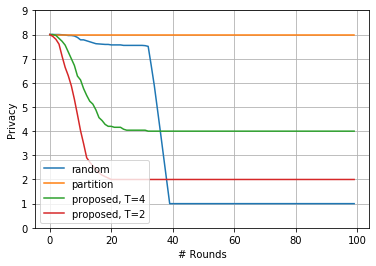

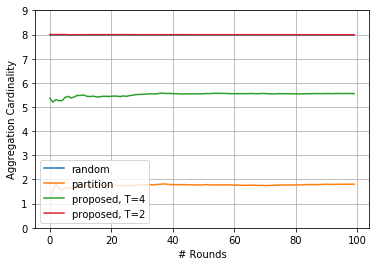

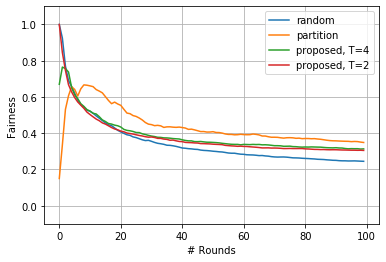

In [113]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

plt.plot(mean_priavcy_pdiff_noSelection[0,:], label='random')
plt.plot(mean_priavcy_pdiff_noSelection[1,:], label='partition')
plt.plot(mean_priavcy_pdiff_noSelection[2,:], label='proposed, T=4')
plt.plot(mean_priavcy_pdiff_noSelection[3,:], label='proposed, T=2')
plt.ylabel('Privacy')
plt.xlabel('# Rounds')
plt.ylim([0,9])
plt.grid()
plt.legend()
plt.show()

plt.plot(mean_Agg_Card_pdiff_noSelection[0,:], label='random')
plt.plot(mean_Agg_Card_pdiff_noSelection[1,:], label='partition')
plt.plot(mean_Agg_Card_pdiff_noSelection[2,:], label='proposed, T=4')
plt.plot(mean_Agg_Card_pdiff_noSelection[3,:], label='proposed, T=2')
plt.ylabel('Aggregation Cardinality')
plt.xlabel('# Rounds')
plt.ylim([0,9])
plt.grid()
plt.legend()
plt.show()

plt.plot(mean_fairness_pdiff_noSelection[0,:], label='random')
plt.plot(mean_fairness_pdiff_noSelection[1,:], label='partition')
plt.plot(mean_fairness_pdiff_noSelection[2,:], label='proposed, T=4')
plt.plot(mean_fairness_pdiff_noSelection[3,:], label='proposed, T=2')
plt.ylabel('Fairness')
plt.xlabel('# Rounds')
plt.ylim([-0.1,1.1])
plt.grid()
plt.legend()
plt.show()

# 3. N=120, K=12

# 3.1. CodeBook Design

In [2]:
N   = 120
K   = 12

Codebook_Proposed_N120_K12_T6 = CodeBookDesign_Bin(N,K,6)
Codebook_Proposed_N120_K12_T4 = CodeBookDesign_Bin(N,K,4)
Codebook_Proposed_N120_K12_T3 = CodeBookDesign_Bin(N,K,3)
# Codebook_Proposed_N120_K12_T2 = CodeBookDesign_Bin(N,K,2)

Codebook_Partition = CodeBookDesign_Partition(N,K)

# print(Codebook_Partition)

@CodeBookDesign_Bin, Codebook Size= 190
@CodeBookDesign_Bin, Codebook Size= 4060
@CodeBookDesign_Bin, Codebook Size= 91389
@CodeBookDesign_Partition, Codebook Size= 10


In [3]:
K=12
T=6 
tmp = K - T/2 + 1
R_max = nCr(N,tmp)/nCr(K,tmp)
print(tmp, R_max)

T=4
tmp = K - T/2 + 1
R_max = nCr(N,tmp)/nCr(K,tmp)
print(tmp, R_max)

T=12
tmp = K - T/2 + 1
R_max = nCr(N,tmp)/nCr(K,tmp)
print(tmp, R_max)

T=18
tmp = K - T/2 + 1
R_max = nCr(N,tmp)/nCr(K,tmp)
print(tmp, R_max)

T=20
tmp = K - T/2 + 1
R_max = nCr(N,tmp)/nCr(K,tmp)
print(tmp, R_max)
# R_max1 = nCr(N,K)/nCr(N-K+T/2-1,T/2-1)

# print(R_max1)

10.0 1758608767254.182
11.0 96723482198980.0
7.0 75110566.81818181
4.0 16595.09090909091
3.0 1276.5454545454545


# 3.1. User Dropout Probability Setting

In [4]:
p_array = np.array([0.1, 0.2, 0.3, 0.4, 0.5]) # dropout rate

# print(p_matrix)
p_sel = np.random.randint(low=0, high=len(p_array), size=(N,))

p_per_user = np.ones((N,))

for i in range(N):
    p_per_user[i] = p_array[p_sel[i]]

print(p_per_user)


[0.1 0.3 0.5 0.5 0.3 0.4 0.2 0.1 0.4 0.2 0.4 0.5 0.1 0.1 0.1 0.2 0.1 0.4
 0.5 0.5 0.1 0.5 0.1 0.4 0.5 0.3 0.2 0.3 0.2 0.2 0.2 0.2 0.4 0.5 0.3 0.3
 0.2 0.5 0.1 0.2 0.5 0.2 0.4 0.5 0.4 0.1 0.3 0.3 0.3 0.4 0.1 0.3 0.5 0.5
 0.5 0.5 0.3 0.1 0.1 0.4 0.1 0.1 0.2 0.1 0.4 0.4 0.5 0.3 0.2 0.5 0.1 0.4
 0.1 0.1 0.5 0.2 0.5 0.5 0.1 0.5 0.1 0.5 0.3 0.2 0.3 0.5 0.2 0.3 0.1 0.1
 0.4 0.3 0.5 0.4 0.1 0.5 0.4 0.5 0.2 0.5 0.2 0.4 0.2 0.5 0.2 0.5 0.1 0.4
 0.2 0.4 0.2 0.4 0.4 0.3 0.2 0.2 0.5 0.2 0.4 0.1]


In [3]:
p_array = np.array([0.3]) # dropout rate

# print(p_matrix)
p_sel = np.random.randint(low=0, high=len(p_array), size=(N,))

p_per_user = np.ones((N,))

for i in range(N):
    p_per_user[i] = p_array[p_sel[i]]

print(p_per_user)

[0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3]


# 3.2. Main Loop 

In [6]:
J = 200  # Total iterations
Max_iter = J

is_print = False
# is_print = False

is_print_tmp = True

is_selection_applied = False

N_schemes = 6

'''
Information about N_schemes
0: Random selection
1: Partition
2: Proposed, T=6
3: Proposed, T=4
4: Proposed, T=3
5: Weighted Random Selection
'''

N_trial = 10

Agg_Card = np.zeros((N_schemes, N_trial, J))
Privacy  = np.zeros((N_schemes, N_trial, J))
Fairness = np.zeros((N_schemes, N_trial, J))


for trial_idx in range(N_trial):
    
    print('trial_idx=',trial_idx)
#     print()
    
    P_random    = []
    P_partition = []
    
    P_proposed_N120_T6  = []
    P_proposed_N120_T4  = []
    P_proposed_N120_T3  = []
    P_proposed_N120_T2  = []
    
    P_w_random = []
    
    for j in range(J):
        
        # Realization of u vector with the same dropout probability
#         u = np.random.binomial(1, 1-p, size=(N))
        
        u = np.ones((N,))
        for u_idx in range(N):
            p_sel = p_per_user[u_idx]
            u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
        
        if is_print:
            print('[iter=',j,'] Surviving vector u=',u)

        if np.sum(u) < K:
            p_tmp = np.zero(N)

            P_random.append(p_tmp)
            P_partition.append(p_tmp)
            P_proposed_N120_T6.append(p_tmp)
            P_proposed_N120_T4.append(p_tmp)
            P_proposed_N120_T3.append(p_tmp)
            P_proposed_N120_T2.append(p_tmp)
        else:
            result = np.where(u == 1)

            ###############################
            # 1. Random Selection
            ###############################
            select = np.random.choice(result[0], K, replace=False)

            p_tmp = np.zeros(N)
            p_tmp[select] = 1

            P_random.append(p_tmp)

            # 1.1 Calculate Privacy
            P = np.array(P_random)
            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)

            if j == 0:
                Privacy[0,trial_idx,j] = partial_sum
            else:
                Privacy[0,trial_idx,j] = np.min([partial_sum, Privacy[0,trial_idx,j-1]])

            # 1.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_random),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[0,trial_idx,j] = acc_card/(j+1)
            
            
            # 1.3. Calculate Fairness
            P = np.array(P_random)
#             P_sum = np.sum(P, axis=0)/(j+1)
#             Fairness[0,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            num_aggr_true = acc_card / K

            if num_aggr_true == 0:
                Fairness[0,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[0,trial_idx,j] = np.max(P_sum) - np.min(P_sum)           
            


            if is_print:
                print('[iter=',j,'] @Random Method, Codebook selection')
                
            

            ###############################
            # 2. Partition
            ###############################

            tmp = Codebook_Partition * u
            codebook_en = 1*(np.sum(tmp,axis=1) == K)
    #         print(np.sum(tmp,axis=1))
    #         print(codebook_en)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',j,'] @Partition Method, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',j,'] @Partition Method, Codebook selection')
                idx_en = np.where(codebook_en == 1)
                
                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Partition[idx_en,:],(codebook_en_num,N))
                    
                    p_tmp = UserSelection_Codebook(P_partition, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Partition[idx_sel[0],:]
                    
#                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

#                 p_tmp = Codebook_Partition[idx_sel[0],:]

            P_partition.append(p_tmp)

            # 2.1 Calculate Privacy
            P = np.array(P_partition)
            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)
            if partial_sum == N+1:
                partial_sum = K

            if j == 0:
                Privacy[1,trial_idx,j] = partial_sum
            else:
                Privacy[1,trial_idx,j] = np.min([partial_sum, Privacy[1,trial_idx,j-1]])

            # 2.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_partition),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[1,trial_idx,j] = acc_card/(j+1)
            
            # 2.3. Calculate Fairness
            P = np.array(P_partition)
#             P_sum = np.sum(P, axis=0)/(j+1)
#             Fairness[1,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            num_aggr_true = acc_card / K
            
            if num_aggr_true == 0:
                Fairness[1,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[1,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            

            ###############################
            # 3. Proposed, T_0 = 6
            ###############################

            tmp = Codebook_Proposed_N120_K12_T6 * u
            codebook_en = 1*(np.sum(tmp,axis=1) == K)
    #         print(np.sum(tmp,axis=1))
    #         print(codebook_en)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',j,'] @Proposed Method, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',j,'] @Proposed Method, Codebook selection')
                idx_en = np.where(codebook_en == 1)
                
                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed_N120_K12_T6[idx_en,:],(codebook_en_num,N))
                    
                    p_tmp = UserSelection_Codebook(P_proposed_N120_T6, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed_N120_K12_T6[idx_sel[0],:]



            P_proposed_N120_T6.append(p_tmp)

            # 3.1 Calculate Privacy
            P = np.array(P_proposed_N120_T6)

            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)
            if partial_sum == N+1:
                partial_sum = K

            if j == 0:
                Privacy[2,trial_idx,j] = partial_sum
            else:
                Privacy[2,trial_idx,j] = np.min([partial_sum, Privacy[2,trial_idx,j-1]])

            # 3.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_proposed_N120_T6),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[2,trial_idx,j] = acc_card/(j+1)
            
            if j == J-1:
                print('Cardinality (T=6),',Agg_Card[2,trial_idx,j])
                tmp___ = np.sum(np.array(P_proposed_N120_T6),axis=0)
                print(tmp___)
                print(np.sum(tmp___))
            
            # 3.3. Calculate Fairness
            P = np.array(P_proposed_N120_T6)
#             P_sum = np.sum(P, axis=0)/(j+1)
#             Fairness[2,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            num_aggr_true = acc_card / K
            
            if num_aggr_true == 0:
                Fairness[2,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[2,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            
            
            ###############################
            # 4. Proposed, T_0 = 4
            ###############################

            tmp = Codebook_Proposed_N120_K12_T4 * u
            codebook_en = 1*(np.sum(tmp,axis=1) == K)
    #         print(np.sum(tmp,axis=1))
    #         print(codebook_en)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',j,'] @Proposed Method 2, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',j,'] @Proposed Method 2, Codebook selection')
                idx_en = np.where(codebook_en == 1)
                
                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed_N120_K12_T4[idx_en,:],(codebook_en_num,N))
                    
                    p_tmp = UserSelection_Codebook(P_proposed_N120_T4, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed_N120_K12_T4[idx_sel[0],:]
                    

    #             print('idx_sel=',idx_sel)

                



            P_proposed_N120_T4.append(p_tmp)

            # 4.1 Calculate Privacy
            P = np.array(P_proposed_N120_T4)

            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)
            if partial_sum == N+1:
                partial_sum = K

            if j == 0:
                Privacy[3,trial_idx,j] = partial_sum
            else:
                Privacy[3,trial_idx,j] = np.min([partial_sum, Privacy[3,trial_idx,j-1]])

                
                
            # 4.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_proposed_N120_T4),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[3,trial_idx,j] = acc_card/(j+1)
            
            
            
            # 4.3. Calculate Fairness
            P = np.array(P_proposed_N120_T4)
            
            num_aggr_true = acc_card / K
            
            if num_aggr_true == 0:
                Fairness[3,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[3,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
                
                
            ###############################
            # 5. Proposed, T_0 = 3
            ###############################

            tmp = Codebook_Proposed_N120_K12_T3 * u
            codebook_en = 1*(np.sum(tmp,axis=1) == K)
    #         print(np.sum(tmp,axis=1))
    #         print(codebook_en)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',j,'] @Proposed Method 2, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',j,'] @Proposed Method 2, Codebook selection')
                idx_en = np.where(codebook_en == 1)
                
                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed_N120_K12_T3[idx_en,:],(codebook_en_num,N))
                    
                    p_tmp = UserSelection_Codebook(P_proposed_N120_T3, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed_N120_K12_T3[idx_sel[0],:]
                    

    #             print('idx_sel=',idx_sel)

                



            P_proposed_N120_T3.append(p_tmp)

            # 5.1 Calculate Privacy
            P = np.array(P_proposed_N120_T3)

            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)
            if partial_sum == N+1:
                partial_sum = K

            if j == 0:
                Privacy[4,trial_idx,j] = partial_sum
            else:
                Privacy[4,trial_idx,j] = np.min([partial_sum, Privacy[4,trial_idx,j-1]])

                
                
            # 5.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_proposed_N120_T3),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[4,trial_idx,j] = acc_card/(j+1)
            
            
            
            # 5.3. Calculate Fairness
            P = np.array(P_proposed_N120_T3)
            
            num_aggr_true = acc_card / K
            
            if num_aggr_true == 0:
                Fairness[4,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[4,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
                
            
            
            ###############################
            # 6. Weighted Random Selection
            ###############################
            
            drop_result = np.where(u == 0)
            
#             print("Weighted Random Selection")
            if j == 0:
                select = np.random.choice(result[0], K, replace=False)
#                 print('select=',select)
            else:
                
#                 print(result[0])
                
                P = np.array(P_w_random)
                P_sum = np.sum(P, axis=0).astype(int)
                
#                 print('P_sum=',P_sum)
                                
                for i in drop_result[0]:
                    P_sum[i] = Max_iter + 1   
                    
#                 print('P_sum=',P_sum)
                
                P_sum_sort = P_sum.argsort()
                
#                 print('P_sum_sort=',P_sum_sort)

                select = P_sum_sort[:K]
#                 print('select=',select)
            
#             select = np.random.choice(result[0], K, replace=False)

            p_tmp = np.zeros(N)
            p_tmp[select] = 1

            P_w_random.append(p_tmp)

            # 6.1 Calculate Privacy
            P = np.array(P_w_random)
            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)

            if j == 0:
                Privacy[5,trial_idx,j] = partial_sum
            else:
                Privacy[5,trial_idx,j] = np.min([partial_sum, Privacy[5,trial_idx,j-1]])

            # 6.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_w_random),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[5,trial_idx,j] = acc_card/(j+1)
            
            
            # 6.3. Calculate Fairness
            P = np.array(P_w_random)
#             P_sum = np.sum(P, axis=0)/(j+1)
#             Fairness[0,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            num_aggr_true = acc_card / K

            if num_aggr_true == 0:
                Fairness[5,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[5,trial_idx,j] = np.max(P_sum) - np.min(P_sum)           
            


            if is_print:
                print('[iter=',j,'] @Weighted Random Method, Codebook selection')
            

            if is_print:
                print()


        # random selection

#     print(Privacy)
#     print()
#     print(Agg_Card)


mean_priavcy_N120_pdiff = np.sum(Privacy, axis=1)/N_trial
print(np.shape(mean_priavcy_N120_pdiff))

mean_Agg_Card_N120_pdiff = np.sum(Agg_Card, axis=1)/N_trial
print(np.shape(mean_Agg_Card_N120_pdiff))

mean_fairness_N120_pdiff = np.sum(Fairness, axis=1)/N_trial
print(np.shape(mean_fairness_N120_pdiff))

trial_idx= 0
Cardinality (T=6), 7.98
[ 9.  9.  9.  9.  9.  9. 12. 12. 12. 12. 12. 12. 19. 19. 19. 19. 19. 19.
 11. 11. 11. 11. 11. 11. 19. 19. 19. 19. 19. 19. 14. 14. 14. 14. 14. 14.
 14. 14. 14. 14. 14. 14. 15. 15. 15. 15. 15. 15. 17. 17. 17. 17. 17. 17.
 11. 11. 11. 11. 11. 11. 12. 12. 12. 12. 12. 12.  8.  8.  8.  8.  8.  8.
 10. 10. 10. 10. 10. 10. 11. 11. 11. 11. 11. 11. 13. 13. 13. 13. 13. 13.
 14. 14. 14. 14. 14. 14. 15. 15. 15. 15. 15. 15. 16. 16. 16. 16. 16. 16.
 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13.]
1596.0
trial_idx= 1


KeyboardInterrupt: 

[5. 5. 5. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 6. 5. 6. 6. 6. 6. 6. 6. 6. 6. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 6. 6. 6. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 4. 6. 6.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
12


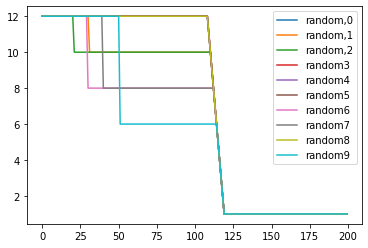

In [23]:
P_w_random_ = np.array(P_w_random)
print(np.sum(P_w_random_[0:51,:],axis=0))
print(P_w_random_[51,:])

P = P_w_random_[0:51,:]
P_rref = rref(P)

P_num = np.count_nonzero(np.array(P_rref),axis = 1)
zero_index = np.where(P_num == 0)
P_num[zero_index] = N+1

partial_sum = np.min(P_num)

print(partial_sum)

plt.plot(Privacy[5,0,:], label='random,0')
plt.plot(Privacy[5,1,:], label='random,1')
plt.plot(Privacy[5,2,:], label='random,2')
plt.plot(Privacy[5,3,:], label='random3')
plt.plot(Privacy[5,4,:], label='random4')
plt.plot(Privacy[5,5,:], label='random5')
plt.plot(Privacy[5,6,:], label='random6')
plt.plot(Privacy[5,7,:], label='random7')
plt.plot(Privacy[5,8,:], label='random8')
plt.plot(Privacy[5,-1,:], label='random9')
plt.legend()
# plt.plot(mean_fairness_N120_pdiff[1,:], label='partition')
# plt.plot(mean_fairness_N120_pdiff[2,:], label='proposed, T=6')
# plt.plot(mean_fairness_N120_pdiff[3,:], label='proposed, T=4')
# plt.plot(mean_fairness_N120_pdiff[4,:], label='proposed, T=3')

In [25]:
import pickle

# mean_priavcy_N120_pdiff = np.sum(Privacy, axis=1)/N_trial
# print(np.shape(mean_priavcy_N120_pdiff))

# mean_Agg_Card_N120_pdiff = np.sum(Agg_Card, axis=1)/N_trial
# print(np.shape(mean_Agg_Card_N120_pdiff))

# mean_fairness_N120_pdiff = np.sum(Fairness, axis=1)/N_trial
# print(np.shape(mean_fairness_N120_pdiff))

pickle.dump(Privacy,  open('./results/Simul_N120_K12_p03_Privacy', 'wb'), -1)
pickle.dump(Agg_Card, open('./results/Simul_N120_K12_p03_Agg_Card', 'wb'), -1)
pickle.dump(Fairness, open('./results/Simul_N120_K12_p03_Fairness', 'wb'), -1)


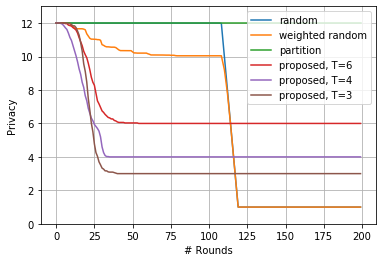

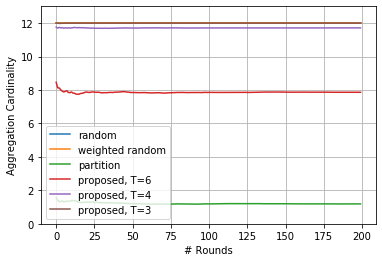

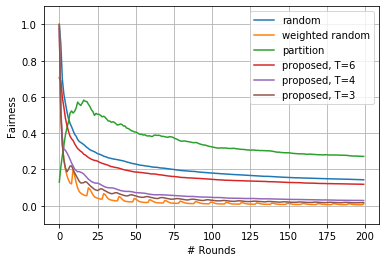

In [6]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

plt.plot(mean_priavcy_N120_pdiff[0,:], label='random')
plt.plot(mean_priavcy_N120_pdiff[5,:], label='weighted random')
plt.plot(mean_priavcy_N120_pdiff[1,:], label='partition')
plt.plot(mean_priavcy_N120_pdiff[2,:], label='proposed, T=6')
plt.plot(mean_priavcy_N120_pdiff[3,:], label='proposed, T=4')
plt.plot(mean_priavcy_N120_pdiff[4,:], label='proposed, T=3')


# plt.plot(mean_priavcy_N120_pdiff[5,:], label='proposed, T=2')
plt.ylabel('Privacy')
plt.xlabel('# Rounds')
plt.ylim([0,13])
plt.grid()
plt.legend()
plt.show()

plt.plot(mean_Agg_Card_N120_pdiff[0,:], label='random')
plt.plot(mean_Agg_Card_N120_pdiff[5,:], label='weighted random')
plt.plot(mean_Agg_Card_N120_pdiff[1,:], label='partition')
plt.plot(mean_Agg_Card_N120_pdiff[2,:], label='proposed, T=6')
plt.plot(mean_Agg_Card_N120_pdiff[3,:], label='proposed, T=4')
plt.plot(mean_Agg_Card_N120_pdiff[4,:], label='proposed, T=3')

# plt.plot(mean_Agg_Card_N120_pdiff[5,:], label='proposed, T=2')
plt.ylabel('Aggregation Cardinality')
plt.xlabel('# Rounds')
plt.ylim([0,13])
plt.grid()
plt.legend()
plt.show()

plt.plot(mean_fairness_N120_pdiff[0,:], label='random')
plt.plot(mean_fairness_N120_pdiff[5,:], label='weighted random')
plt.plot(mean_fairness_N120_pdiff[1,:], label='partition')
plt.plot(mean_fairness_N120_pdiff[2,:], label='proposed, T=6')
plt.plot(mean_fairness_N120_pdiff[3,:], label='proposed, T=4')
plt.plot(mean_fairness_N120_pdiff[4,:], label='proposed, T=3')

# plt.plot(mean_fairness_N120_pdiff[5,:], label='proposed, T=2')
plt.ylabel('Fairness')
plt.xlabel('# Rounds')
plt.ylim([-0.1,1.1])
plt.grid()
plt.legend()
plt.show()

In [192]:
J = 150  # Total iterations

is_print = False
# is_print = False

is_print_tmp = True

is_selection_applied = False

N_schemes = 5

N_trial = 100

Agg_Card = np.zeros((N_schemes, N_trial, J))
Privacy  = np.zeros((N_schemes, N_trial, J))
Fairness = np.zeros((N_schemes, N_trial, J))


for trial_idx in range(N_trial):
    
    print('trial_idx=',trial_idx)
#     print()
    
    P_random    = []
    P_partition = []
    
    P_proposed_N120_T6  = []
    P_proposed_N120_T4  = []
    P_proposed_N120_T3  = []
    P_proposed_N120_T2  = []
    
    for j in range(J):
        
        # Realization of u vector with the same dropout probability
#         u = np.random.binomial(1, 1-p, size=(N))
        
        u = np.ones((N,))
        for u_idx in range(N):
            p_sel = p_per_user[u_idx]
            u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
        
        if is_print:
            print('[iter=',j,'] Surviving vector u=',u)

        if np.sum(u) < K:
            p_tmp = np.zero(N)

            P_random.append(p_tmp)
            P_partition.append(p_tmp)
            P_proposed_N120_T6.append(p_tmp)
            P_proposed_N120_T4.append(p_tmp)
            P_proposed_N120_T3.append(p_tmp)
            P_proposed_N120_T2.append(p_tmp)
        else:
            result = np.where(u == 1)

            ###############################
            # 1. Random Selection
            ###############################
            select = np.random.choice(result[0], K, replace=False)

            p_tmp = np.zeros(N)
            p_tmp[select] = 1

            P_random.append(p_tmp)

            # 1.1 Calculate Privacy
            P = np.array(P_random)
            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)

            if j == 0:
                Privacy[0,trial_idx,j] = partial_sum
            else:
                Privacy[0,trial_idx,j] = np.min([partial_sum, Privacy[0,trial_idx,j-1]])

            # 1.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_random),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[0,trial_idx,j] = acc_card/(j+1)
            
            
            # 1.3. Calculate Fairness
            P = np.array(P_random)
#             P_sum = np.sum(P, axis=0)/(j+1)
#             Fairness[0,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            num_aggr_true = acc_card / K

            if num_aggr_true == 0:
                Fairness[0,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[0,trial_idx,j] = np.max(P_sum) - np.min(P_sum)           
            


            if is_print:
                print('[iter=',j,'] @Random Method, Codebook selection')
                
            

            ###############################
            # 2. Partition
            ###############################

            tmp = Codebook_Partition * u
            codebook_en = 1*(np.sum(tmp,axis=1) == K)
    #         print(np.sum(tmp,axis=1))
    #         print(codebook_en)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',j,'] @Partition Method, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',j,'] @Partition Method, Codebook selection')
                idx_en = np.where(codebook_en == 1)
                
                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Partition[idx_en,:],(codebook_en_num,N))
                    
                    p_tmp = UserSelection_Codebook(P_partition, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Partition[idx_sel[0],:]
                    
#                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

#                 p_tmp = Codebook_Partition[idx_sel[0],:]

            P_partition.append(p_tmp)

            # 2.1 Calculate Privacy
            P = np.array(P_partition)
            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)
            if partial_sum == N+1:
                partial_sum = K

            if j == 0:
                Privacy[1,trial_idx,j] = partial_sum
            else:
                Privacy[1,trial_idx,j] = np.min([partial_sum, Privacy[1,trial_idx,j-1]])

            # 2.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_partition),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[1,trial_idx,j] = acc_card/(j+1)
            
            # 2.3. Calculate Fairness
            P = np.array(P_partition)
#             P_sum = np.sum(P, axis=0)/(j+1)
#             Fairness[1,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            num_aggr_true = acc_card / K
            
            if num_aggr_true == 0:
                Fairness[1,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[1,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            

            ###############################
            # 3. Proposed, T_0 = 6
            ###############################

            tmp = Codebook_Proposed_N120_K12_T6 * u
            codebook_en = 1*(np.sum(tmp,axis=1) == K)
    #         print(np.sum(tmp,axis=1))
    #         print(codebook_en)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',j,'] @Proposed Method, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',j,'] @Proposed Method, Codebook selection')
                idx_en = np.where(codebook_en == 1)
                
                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed_N120_K12_T6[idx_en,:],(codebook_en_num,N))
                    
                    p_tmp = UserSelection_Codebook(P_proposed_N120_T6, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed_N120_K12_T6[idx_sel[0],:]

            P_proposed_N120_T6.append(p_tmp)

            # 3.1 Calculate Privacy
            P = np.array(P_proposed_N120_T6)
            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)
            if partial_sum == N+1:
                partial_sum = K

            if j == 0:
                Privacy[2,trial_idx,j] = partial_sum
            else:
                Privacy[2,trial_idx,j] = np.min([partial_sum, Privacy[2,trial_idx,j-1]])

            # 3.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_proposed_N120_T6),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[2,trial_idx,j] = acc_card/(j+1)
            
            # 3.3. Calculate Fairness
            P = np.array(P_proposed_N120_T6)
#             P_sum = np.sum(P, axis=0)/(j+1)
#             Fairness[2,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            num_aggr_true = acc_card / K
            
            if num_aggr_true == 0:
                Fairness[2,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[2,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            
            
            ###############################
            # 4. Proposed, T_0 = 4
            ###############################

            tmp = Codebook_Proposed_N120_K12_T4 * u
            codebook_en = 1*(np.sum(tmp,axis=1) == K)
    #         print(np.sum(tmp,axis=1))
    #         print(codebook_en)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',j,'] @Proposed Method 2, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',j,'] @Proposed Method 2, Codebook selection')
                idx_en = np.where(codebook_en == 1)

                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed_N120_K12_T4[idx_en,:],(codebook_en_num,N))

                    p_tmp = UserSelection_Codebook(P_proposed_N120_T4, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed_N120_K12_T4[idx_sel[0],:]


    #             print('idx_sel=',idx_sel)





            P_proposed_N120_T4.append(p_tmp)

            # 4.1 Calculate Privacy
            P = np.array(P_proposed_N120_T4)

            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)
            if partial_sum == N+1:
                partial_sum = K

            if j == 0:
                Privacy[3,trial_idx,j] = partial_sum
            else:
                Privacy[3,trial_idx,j] = np.min([partial_sum, Privacy[3,trial_idx,j-1]])



            # 4.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_proposed_N120_T4),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[3,trial_idx,j] = acc_card/(j+1)



            # 4.3. Calculate Fairness
            P = np.array(P_proposed_N120_T4)

            num_aggr_true = acc_card / K

            if num_aggr_true == 0:
                Fairness[3,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[3,trial_idx,j] = np.max(P_sum) - np.min(P_sum)


            ###############################
            # 5. Proposed, T_0 = 3
            ###############################

            tmp = Codebook_Proposed_N120_K12_T3 * u
            codebook_en = 1*(np.sum(tmp,axis=1) == K)
    #         print(np.sum(tmp,axis=1))
    #         print(codebook_en)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',j,'] @Proposed Method 2, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',j,'] @Proposed Method 2, Codebook selection')
                idx_en = np.where(codebook_en == 1)

                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed_N120_K12_T3[idx_en,:],(codebook_en_num,N))

                    p_tmp = UserSelection_Codebook(P_proposed_N120_T3, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed_N120_K12_T3[idx_sel[0],:]


    #             print('idx_sel=',idx_sel)





            P_proposed_N120_T3.append(p_tmp)

            # 5.1 Calculate Privacy
            P = np.array(P_proposed_N120_T3)

            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)
            if partial_sum == N+1:
                partial_sum = K

            if j == 0:
                Privacy[4,trial_idx,j] = partial_sum
            else:
                Privacy[4,trial_idx,j] = np.min([partial_sum, Privacy[4,trial_idx,j-1]])



            # 5.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_proposed_N120_T3),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[4,trial_idx,j] = acc_card/(j+1)



            # 5.3. Calculate Fairness
            P = np.array(P_proposed_N120_T3)

            num_aggr_true = acc_card / K

            if num_aggr_true == 0:
                Fairness[4,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[4,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
                
            
            
            ###############################
            # 6. Proposed, T_0 = 2
            ###############################

#             tmp = Codebook_Proposed_N120_K12_T2 * u
#             codebook_en = 1*(np.sum(tmp,axis=1) == K)
#     #         print(np.sum(tmp,axis=1))
#     #         print(codebook_en)

#             if np.sum(codebook_en) == 0:
#                 if is_print:
#                     print('[iter=',j,'] @Proposed Method 2, there is no available codebook')
#                 p_tmp = np.zeros(N)
#             else:
#                 if is_print:
#                     print('[iter=',j,'] @Proposed Method 2, Codebook selection')
#                 idx_en = np.where(codebook_en == 1)
                
#                 if is_selection_applied:
#                     codebook_en_num = np.sum(codebook_en)
#                     Codebook_En = np.reshape(Codebook_Proposed_N120_K12_T2[idx_en,:],(codebook_en_num,N))
                    
#                     p_tmp = UserSelection_Codebook(P_proposed_N120_T2, Codebook_En)
#                 else:
#                     idx_sel = np.random.choice(idx_en[0], 1, replace=False)
#                     p_tmp = Codebook_Proposed_N120_K12_T2[idx_sel[0],:]
                    

#     #             print('idx_sel=',idx_sel)

                



#             P_proposed_N120_T2.append(p_tmp)

#             # 6.1 Calculate Privacy
#             P = np.array(P_proposed_N120_T2)

#             P_rref = rref(P)

#             P_num = np.count_nonzero(np.array(P_rref),axis = 1)
#             zero_index = np.where(P_num == 0)
#             P_num[zero_index] = N+1

#             partial_sum = np.min(P_num)
#             if partial_sum == N+1:
#                 partial_sum = K

#             if j == 0:
#                 Privacy[5,trial_idx,j] = partial_sum
#             else:
#                 Privacy[5,trial_idx,j] = np.min([partial_sum, Privacy[5,trial_idx,j-1]])

                
                
#             # 6.2. Calculate Aggregation Cardinality
#             acc_card = np.sum(np.array(P_proposed_N120_T2),axis=0)
#             acc_card = np.sum(acc_card)

#             Agg_Card[5,trial_idx,j] = acc_card/(j+1)
            
            
            
#             # 6.3. Calculate Fairness
#             P = np.array(P_proposed_N120_T2)
            
#             num_aggr_true = acc_card / K
            
#             if num_aggr_true == 0:
#                 Fairness[5,trial_idx,j] = 0
#             else:
#                 P_sum = np.sum(P, axis=0)/num_aggr_true
#                 Fairness[5,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            

            if is_print:
                print()


        # random selection

#     print(Privacy)
#     print()
#     print(Agg_Card)


mean_priavcy_N120_pdiff_noSelection = np.sum(Privacy, axis=1)/N_trial
print(np.shape(mean_priavcy_N120_pdiff_noSelection))

mean_Agg_Card_N120_pdiff_noSelection = np.sum(Agg_Card, axis=1)/N_trial
print(np.shape(mean_Agg_Card_N120_pdiff_noSelection))

mean_fairness_N120_pdiff_noSelection = np.sum(Fairness, axis=1)/N_trial
print(np.shape(mean_fairness_N120_pdiff_noSelection))

trial_idx= 0
trial_idx= 1
trial_idx= 2
trial_idx= 3
trial_idx= 4
(5, 150)
(5, 150)
(5, 150)


In [193]:
print(np.sum(P_proposed_N120_T6, axis=0))

[15. 15. 15. 15. 15. 15.  8.  8.  8.  8.  8.  8.  6.  6.  6.  6.  6.  6.
 16. 16. 16. 16. 16. 16.  8.  8.  8.  8.  8.  8. 15. 15. 15. 15. 15. 15.
  7.  7.  7.  7.  7.  7. 11. 11. 11. 11. 11. 11.  7.  7.  7.  7.  7.  7.
 10. 10. 10. 10. 10. 10. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13.
  7.  7.  7.  7.  7.  7. 15. 15. 15. 15. 15. 15. 13. 13. 13. 13. 13. 13.
 12. 12. 12. 12. 12. 12.  5.  5.  5.  5.  5.  5. 10. 10. 10. 10. 10. 10.
  7.  7.  7.  7.  7.  7. 10. 10. 10. 10. 10. 10.]


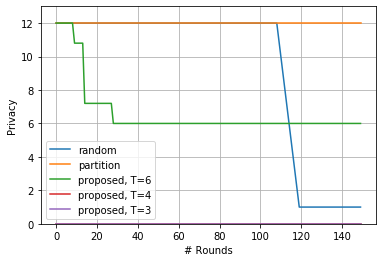

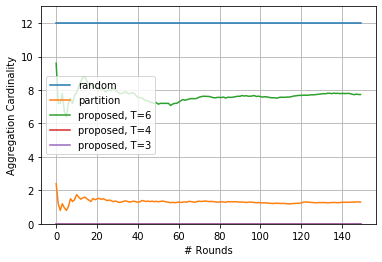

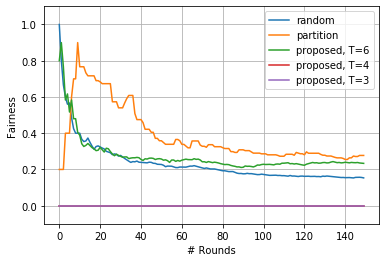

In [173]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

plt.plot(mean_priavcy_N120_pdiff_noSelection[0,:], label='random')
plt.plot(mean_priavcy_N120_pdiff_noSelection[1,:], label='partition')
plt.plot(mean_priavcy_N120_pdiff_noSelection[2,:], label='proposed, T=6')
plt.plot(mean_priavcy_N120_pdiff_noSelection[3,:], label='proposed, T=4')
plt.plot(mean_priavcy_N120_pdiff_noSelection[4,:], label='proposed, T=3')
# plt.plot(mean_priavcy_N120_pdiff[5,:], label='proposed, T=2')
plt.ylabel('Privacy')
plt.xlabel('# Rounds')
plt.ylim([0,13])
plt.grid()
plt.legend()
plt.show()

plt.plot(mean_Agg_Card_N120_pdiff_noSelection[0,:], label='random')
plt.plot(mean_Agg_Card_N120_pdiff_noSelection[1,:], label='partition')
plt.plot(mean_Agg_Card_N120_pdiff_noSelection[2,:], label='proposed, T=6')
plt.plot(mean_Agg_Card_N120_pdiff_noSelection[3,:], label='proposed, T=4')
plt.plot(mean_Agg_Card_N120_pdiff_noSelection[4,:], label='proposed, T=3')
# plt.plot(mean_Agg_Card_N120_pdiff[5,:], label='proposed, T=2')
plt.ylabel('Aggregation Cardinality')
plt.xlabel('# Rounds')
plt.ylim([0,13])
plt.grid()
plt.legend()
plt.show()

plt.plot(mean_fairness_N120_pdiff_noSelection[0,:], label='random')
plt.plot(mean_fairness_N120_pdiff_noSelection[1,:], label='partition')
plt.plot(mean_fairness_N120_pdiff_noSelection[2,:], label='proposed, T=6')
plt.plot(mean_fairness_N120_pdiff_noSelection[3,:], label='proposed, T=4')
plt.plot(mean_fairness_N120_pdiff_noSelection[4,:], label='proposed, T=3')
# plt.plot(mean_fairness_N120_pdiff[5,:], label='proposed, T=2')
plt.ylabel('Fairness')
plt.xlabel('# Rounds')
plt.ylim([-0.1,1.1])
plt.grid()
plt.legend()
plt.show()

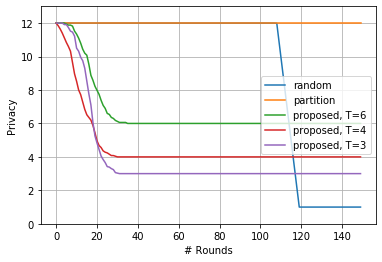

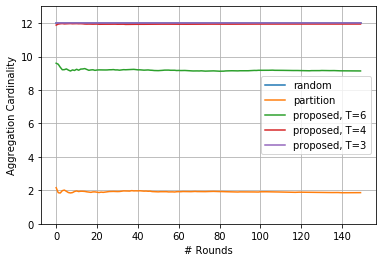

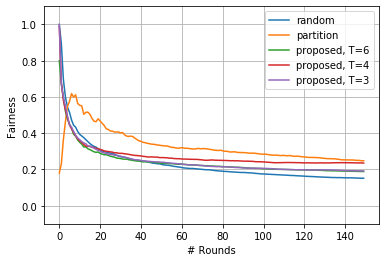

In [135]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

plt.plot(mean_priavcy_N120_pdiff_noSelection[0,:], label='random')
plt.plot(mean_priavcy_N120_pdiff_noSelection[1,:], label='partition')
plt.plot(mean_priavcy_N120_pdiff_noSelection[2,:], label='proposed, T=6')
plt.plot(mean_priavcy_N120_pdiff_noSelection[3,:], label='proposed, T=4')
plt.plot(mean_priavcy_N120_pdiff_noSelection[4,:], label='proposed, T=3')
# plt.plot(mean_priavcy_N120_pdiff[5,:], label='proposed, T=2')
plt.ylabel('Privacy')
plt.xlabel('# Rounds')
plt.ylim([0,13])
plt.grid()
plt.legend()
plt.show()

plt.plot(mean_Agg_Card_N120_pdiff_noSelection[0,:], label='random')
plt.plot(mean_Agg_Card_N120_pdiff_noSelection[1,:], label='partition')
plt.plot(mean_Agg_Card_N120_pdiff_noSelection[2,:], label='proposed, T=6')
plt.plot(mean_Agg_Card_N120_pdiff_noSelection[3,:], label='proposed, T=4')
plt.plot(mean_Agg_Card_N120_pdiff_noSelection[4,:], label='proposed, T=3')
# plt.plot(mean_Agg_Card_N120_pdiff[5,:], label='proposed, T=2')
plt.ylabel('Aggregation Cardinality')
plt.xlabel('# Rounds')
plt.ylim([0,13])
plt.grid()
plt.legend()
plt.show()

plt.plot(mean_fairness_N120_pdiff_noSelection[0,:], label='random')
plt.plot(mean_fairness_N120_pdiff_noSelection[1,:], label='partition')
plt.plot(mean_fairness_N120_pdiff_noSelection[2,:], label='proposed, T=6')
plt.plot(mean_fairness_N120_pdiff_noSelection[3,:], label='proposed, T=4')
plt.plot(mean_fairness_N120_pdiff_noSelection[4,:], label='proposed, T=3')
# plt.plot(mean_fairness_N120_pdiff[5,:], label='proposed, T=2')
plt.ylabel('Fairness')
plt.xlabel('# Rounds')
plt.ylim([-0.1,1.1])
plt.grid()
plt.legend()
plt.show()

In [11]:
J = 500  # Total iterations
Max_iter = J

is_print = False
# is_print = False

is_print_tmp = True

is_selection_applied = False

N_schemes = 6

'''
Information about N_schemes
0: Random selection
1: Partition
2: Proposed, T=6
3: Proposed, T=4
4: Proposed, T=3
5: Weighted Random Selection
'''

N_trial = 1000

Agg_Card = np.zeros((N_schemes, N_trial, J))
Privacy  = np.zeros((N_schemes, N_trial, J))
Fairness = np.zeros((N_schemes, N_trial, J))


for trial_idx in range(N_trial):
    
    print('trial_idx=',trial_idx)
#     print()
    
    P_random    = []
    P_partition = []
    
    P_proposed_N120_T6  = []
    P_proposed_N120_T4  = []
    P_proposed_N120_T3  = []
    P_proposed_N120_T2  = []
    
    P_w_random = []
    
    for j in range(J):
        
        # Realization of u vector with the same dropout probability
#         u = np.random.binomial(1, 1-p, size=(N))
        
        u = np.ones((N,))
        for u_idx in range(N):
            p_sel = p_per_user[u_idx]
            u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
        
        if is_print:
            print('[iter=',j,'] Surviving vector u=',u)

        if np.sum(u) < K:
            p_tmp = np.zero(N)

            P_random.append(p_tmp)
            P_partition.append(p_tmp)
            P_proposed_N120_T6.append(p_tmp)
            P_proposed_N120_T4.append(p_tmp)
            P_proposed_N120_T3.append(p_tmp)
            P_proposed_N120_T2.append(p_tmp)
        else:
            result = np.where(u == 1)

            ###############################
            # 3. Proposed, T_0 = 6
            ###############################

            tmp = Codebook_Proposed_N120_K12_T6 * u
            codebook_en = 1*(np.sum(tmp,axis=1) == K)
    #         print(np.sum(tmp,axis=1))
    #         print(codebook_en)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',j,'] @Proposed Method, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',j,'] @Proposed Method, Codebook selection')
                idx_en = np.where(codebook_en == 1)
                
                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed_N120_K12_T6[idx_en,:],(codebook_en_num,N))
                    
                    p_tmp = UserSelection_Codebook(P_proposed_N120_T6, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed_N120_K12_T6[idx_sel[0],:]



            P_proposed_N120_T6.append(p_tmp)

            # 3.1 Calculate Privacy
            P = np.array(P_proposed_N120_T6)

            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)
            if partial_sum == N+1:
                partial_sum = K

            if j == 0:
                Privacy[2,trial_idx,j] = partial_sum
            else:
                Privacy[2,trial_idx,j] = np.min([partial_sum, Privacy[2,trial_idx,j-1]])

            # 3.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_proposed_N120_T6),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[2,trial_idx,j] = acc_card/(j+1)
            
            if j % 100 == 99:
                print(j,'Cardinality (T=6),',Agg_Card[2,trial_idx,j])
            
            # 3.3. Calculate Fairness
            P = np.array(P_proposed_N120_T6)
#             P_sum = np.sum(P, axis=0)/(j+1)
#             Fairness[2,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            num_aggr_true = acc_card / K
            
            if num_aggr_true == 0:
                Fairness[2,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[2,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            


            if is_print:
                print('[iter=',j,'] @Weighted Random Method, Codebook selection')
            

            if is_print:
                print()


        # random selection

#     print(Privacy)
#     print()
#     print(Agg_Card)


mean_priavcy_N120_pdiff = np.sum(Privacy, axis=1)/N_trial
print(np.shape(mean_priavcy_N120_pdiff))

mean_Agg_Card_N120_pdiff = np.sum(Agg_Card, axis=1)/N_trial
print(np.shape(mean_Agg_Card_N120_pdiff))

print(mean_Agg_Card_N120_pdiff[2,-1])

mean_fairness_N120_pdiff = np.sum(Fairness, axis=1)/N_trial
print(np.shape(mean_fairness_N120_pdiff))

trial_idx= 0
99 Cardinality (T=6), 7.68
199 Cardinality (T=6), 7.62
299 Cardinality (T=6), 7.88
399 Cardinality (T=6), 8.01
499 Cardinality (T=6), 8.016
trial_idx= 1
99 Cardinality (T=6), 7.92
199 Cardinality (T=6), 8.52
299 Cardinality (T=6), 8.56
399 Cardinality (T=6), 8.7
499 Cardinality (T=6), 8.688
trial_idx= 2
99 Cardinality (T=6), 8.52
199 Cardinality (T=6), 8.52
299 Cardinality (T=6), 8.44
399 Cardinality (T=6), 8.43
499 Cardinality (T=6), 8.424
trial_idx= 3
99 Cardinality (T=6), 7.44
199 Cardinality (T=6), 7.68
299 Cardinality (T=6), 7.48
399 Cardinality (T=6), 7.62
499 Cardinality (T=6), 7.704
trial_idx= 4
99 Cardinality (T=6), 8.64
199 Cardinality (T=6), 8.76
299 Cardinality (T=6), 8.6
399 Cardinality (T=6), 8.46
499 Cardinality (T=6), 8.304
trial_idx= 5
99 Cardinality (T=6), 7.8
199 Cardinality (T=6), 8.04
299 Cardinality (T=6), 7.96
399 Cardinality (T=6), 8.1
499 Cardinality (T=6), 8.136
trial_idx= 6
99 Cardinality (T=6), 8.16
199 Cardinality (T=6), 8.58
299 Cardinality (T

399 Cardinality (T=6), 8.25
499 Cardinality (T=6), 8.16
trial_idx= 54
99 Cardinality (T=6), 7.56
199 Cardinality (T=6), 7.62
299 Cardinality (T=6), 7.84
399 Cardinality (T=6), 8.28
499 Cardinality (T=6), 8.088
trial_idx= 55
99 Cardinality (T=6), 8.16
199 Cardinality (T=6), 7.68
299 Cardinality (T=6), 8.04
399 Cardinality (T=6), 8.13
499 Cardinality (T=6), 8.352
trial_idx= 56
99 Cardinality (T=6), 8.28
199 Cardinality (T=6), 8.94
299 Cardinality (T=6), 8.72
399 Cardinality (T=6), 8.52
499 Cardinality (T=6), 8.52
trial_idx= 57
99 Cardinality (T=6), 8.52
199 Cardinality (T=6), 8.22
299 Cardinality (T=6), 8.48
399 Cardinality (T=6), 8.37
499 Cardinality (T=6), 8.28
trial_idx= 58
99 Cardinality (T=6), 8.76
199 Cardinality (T=6), 8.58
299 Cardinality (T=6), 8.52
399 Cardinality (T=6), 8.28
499 Cardinality (T=6), 8.28
trial_idx= 59
99 Cardinality (T=6), 8.16
199 Cardinality (T=6), 8.58
299 Cardinality (T=6), 8.72
399 Cardinality (T=6), 8.61
499 Cardinality (T=6), 8.52
trial_idx= 60
99 Cardina

199 Cardinality (T=6), 8.58
299 Cardinality (T=6), 8.52
399 Cardinality (T=6), 8.52
499 Cardinality (T=6), 8.544
trial_idx= 108
99 Cardinality (T=6), 8.16
199 Cardinality (T=6), 8.1
299 Cardinality (T=6), 8.36
399 Cardinality (T=6), 8.37
499 Cardinality (T=6), 8.376
trial_idx= 109
99 Cardinality (T=6), 7.68
199 Cardinality (T=6), 7.8
299 Cardinality (T=6), 8.16
399 Cardinality (T=6), 8.07
499 Cardinality (T=6), 7.992
trial_idx= 110
99 Cardinality (T=6), 7.8
199 Cardinality (T=6), 8.04
299 Cardinality (T=6), 8.2
399 Cardinality (T=6), 8.34
499 Cardinality (T=6), 8.184
trial_idx= 111
99 Cardinality (T=6), 7.32
199 Cardinality (T=6), 7.5
299 Cardinality (T=6), 7.88
399 Cardinality (T=6), 8.16
499 Cardinality (T=6), 8.232
trial_idx= 112
99 Cardinality (T=6), 8.52
199 Cardinality (T=6), 8.58
299 Cardinality (T=6), 8.52
399 Cardinality (T=6), 8.4
499 Cardinality (T=6), 8.112
trial_idx= 113
99 Cardinality (T=6), 9.36
199 Cardinality (T=6), 9.66
299 Cardinality (T=6), 8.88
399 Cardinality (T=6

299 Cardinality (T=6), 8.0
399 Cardinality (T=6), 8.34
499 Cardinality (T=6), 8.232
trial_idx= 161
99 Cardinality (T=6), 8.16
199 Cardinality (T=6), 8.1
299 Cardinality (T=6), 8.44
399 Cardinality (T=6), 8.4
499 Cardinality (T=6), 8.208
trial_idx= 162
99 Cardinality (T=6), 8.64
199 Cardinality (T=6), 8.4
299 Cardinality (T=6), 8.44
399 Cardinality (T=6), 8.4
499 Cardinality (T=6), 8.544
trial_idx= 163
99 Cardinality (T=6), 7.92
199 Cardinality (T=6), 7.98
299 Cardinality (T=6), 7.96
399 Cardinality (T=6), 8.19
499 Cardinality (T=6), 8.304
trial_idx= 164
99 Cardinality (T=6), 7.32
199 Cardinality (T=6), 7.38
299 Cardinality (T=6), 7.68
399 Cardinality (T=6), 7.86
499 Cardinality (T=6), 7.896
trial_idx= 165
99 Cardinality (T=6), 8.52
199 Cardinality (T=6), 8.64
299 Cardinality (T=6), 8.6
399 Cardinality (T=6), 8.34
499 Cardinality (T=6), 8.208
trial_idx= 166
99 Cardinality (T=6), 8.4
199 Cardinality (T=6), 8.22
299 Cardinality (T=6), 8.16
399 Cardinality (T=6), 8.25
499 Cardinality (T=6)

499 Cardinality (T=6), 8.4
trial_idx= 214
99 Cardinality (T=6), 8.88
199 Cardinality (T=6), 8.7
299 Cardinality (T=6), 8.36
399 Cardinality (T=6), 8.4
499 Cardinality (T=6), 8.28
trial_idx= 215
99 Cardinality (T=6), 9.48
199 Cardinality (T=6), 9.24
299 Cardinality (T=6), 9.0
399 Cardinality (T=6), 8.97
499 Cardinality (T=6), 8.88
trial_idx= 216
99 Cardinality (T=6), 9.0
199 Cardinality (T=6), 8.58
299 Cardinality (T=6), 8.36
399 Cardinality (T=6), 8.37
499 Cardinality (T=6), 8.256
trial_idx= 217
99 Cardinality (T=6), 8.64
199 Cardinality (T=6), 8.16
299 Cardinality (T=6), 8.32
399 Cardinality (T=6), 8.37
499 Cardinality (T=6), 8.424
trial_idx= 218
99 Cardinality (T=6), 8.52
199 Cardinality (T=6), 8.4
299 Cardinality (T=6), 8.16
399 Cardinality (T=6), 8.22
499 Cardinality (T=6), 8.448
trial_idx= 219
99 Cardinality (T=6), 8.28
199 Cardinality (T=6), 7.98
299 Cardinality (T=6), 7.92
399 Cardinality (T=6), 7.98
499 Cardinality (T=6), 7.992
trial_idx= 220
99 Cardinality (T=6), 7.2
199 Cardi

99 Cardinality (T=6), 7.44
199 Cardinality (T=6), 7.56
299 Cardinality (T=6), 7.72
399 Cardinality (T=6), 7.86
499 Cardinality (T=6), 7.8
trial_idx= 268
99 Cardinality (T=6), 9.0
199 Cardinality (T=6), 8.94
299 Cardinality (T=6), 8.72
399 Cardinality (T=6), 8.82
499 Cardinality (T=6), 8.808
trial_idx= 269
99 Cardinality (T=6), 8.64
199 Cardinality (T=6), 8.52
299 Cardinality (T=6), 8.52
399 Cardinality (T=6), 8.64
499 Cardinality (T=6), 8.808
trial_idx= 270
99 Cardinality (T=6), 8.52
199 Cardinality (T=6), 8.34
299 Cardinality (T=6), 8.28
399 Cardinality (T=6), 8.43
499 Cardinality (T=6), 8.424
trial_idx= 271
99 Cardinality (T=6), 8.64
199 Cardinality (T=6), 7.8
299 Cardinality (T=6), 7.8
399 Cardinality (T=6), 7.95
499 Cardinality (T=6), 8.016
trial_idx= 272
99 Cardinality (T=6), 8.04
199 Cardinality (T=6), 7.92
299 Cardinality (T=6), 8.24
399 Cardinality (T=6), 8.49
499 Cardinality (T=6), 8.376
trial_idx= 273
99 Cardinality (T=6), 8.64
199 Cardinality (T=6), 7.98
299 Cardinality (T=6

199 Cardinality (T=6), 9.12
299 Cardinality (T=6), 8.68
399 Cardinality (T=6), 8.37
499 Cardinality (T=6), 8.424
trial_idx= 321
99 Cardinality (T=6), 8.16
199 Cardinality (T=6), 8.46
299 Cardinality (T=6), 8.28
399 Cardinality (T=6), 8.43
499 Cardinality (T=6), 8.4
trial_idx= 322
99 Cardinality (T=6), 8.04
199 Cardinality (T=6), 8.04
299 Cardinality (T=6), 7.88
399 Cardinality (T=6), 8.19
499 Cardinality (T=6), 8.28
trial_idx= 323
99 Cardinality (T=6), 7.8
199 Cardinality (T=6), 7.86
299 Cardinality (T=6), 7.68
399 Cardinality (T=6), 8.07
499 Cardinality (T=6), 8.04
trial_idx= 324
99 Cardinality (T=6), 8.64
199 Cardinality (T=6), 8.88
299 Cardinality (T=6), 8.72
399 Cardinality (T=6), 8.7
499 Cardinality (T=6), 8.616
trial_idx= 325
99 Cardinality (T=6), 9.48
199 Cardinality (T=6), 8.7
299 Cardinality (T=6), 8.56
399 Cardinality (T=6), 8.34
499 Cardinality (T=6), 8.184
trial_idx= 326
99 Cardinality (T=6), 8.4
199 Cardinality (T=6), 8.4
299 Cardinality (T=6), 8.04
399 Cardinality (T=6), 

399 Cardinality (T=6), 8.34
499 Cardinality (T=6), 8.28
trial_idx= 374
99 Cardinality (T=6), 9.12
199 Cardinality (T=6), 8.7
299 Cardinality (T=6), 8.8
399 Cardinality (T=6), 8.88
499 Cardinality (T=6), 9.048
trial_idx= 375
99 Cardinality (T=6), 8.88
199 Cardinality (T=6), 8.64
299 Cardinality (T=6), 8.88
399 Cardinality (T=6), 8.64
499 Cardinality (T=6), 8.424
trial_idx= 376
99 Cardinality (T=6), 9.0
199 Cardinality (T=6), 8.7
299 Cardinality (T=6), 8.36
399 Cardinality (T=6), 8.52
499 Cardinality (T=6), 8.688
trial_idx= 377
99 Cardinality (T=6), 8.4
199 Cardinality (T=6), 8.64
299 Cardinality (T=6), 8.32
399 Cardinality (T=6), 8.34
499 Cardinality (T=6), 8.4
trial_idx= 378
99 Cardinality (T=6), 8.04
199 Cardinality (T=6), 8.88
299 Cardinality (T=6), 8.76
399 Cardinality (T=6), 8.64
499 Cardinality (T=6), 8.64
trial_idx= 379
99 Cardinality (T=6), 7.56
199 Cardinality (T=6), 8.1
299 Cardinality (T=6), 8.32
399 Cardinality (T=6), 8.34
499 Cardinality (T=6), 8.448
trial_idx= 380
99 Cardi

499 Cardinality (T=6), 8.28
trial_idx= 427
99 Cardinality (T=6), 7.8
199 Cardinality (T=6), 7.86
299 Cardinality (T=6), 8.28
399 Cardinality (T=6), 8.58
499 Cardinality (T=6), 8.472
trial_idx= 428
99 Cardinality (T=6), 7.2
199 Cardinality (T=6), 7.56
299 Cardinality (T=6), 8.04
399 Cardinality (T=6), 8.04
499 Cardinality (T=6), 7.92
trial_idx= 429
99 Cardinality (T=6), 7.44
199 Cardinality (T=6), 7.98
299 Cardinality (T=6), 8.2
399 Cardinality (T=6), 8.1
499 Cardinality (T=6), 8.232
trial_idx= 430
99 Cardinality (T=6), 8.16
199 Cardinality (T=6), 8.52
299 Cardinality (T=6), 8.8
399 Cardinality (T=6), 8.76
499 Cardinality (T=6), 8.736
trial_idx= 431
99 Cardinality (T=6), 7.92
199 Cardinality (T=6), 7.98
299 Cardinality (T=6), 8.04
399 Cardinality (T=6), 8.22
499 Cardinality (T=6), 8.184
trial_idx= 432
99 Cardinality (T=6), 7.2
199 Cardinality (T=6), 8.04
299 Cardinality (T=6), 7.96
399 Cardinality (T=6), 8.31
499 Cardinality (T=6), 8.208
trial_idx= 433
99 Cardinality (T=6), 9.0
199 Card

99 Cardinality (T=6), 8.16
199 Cardinality (T=6), 7.86
299 Cardinality (T=6), 7.8
399 Cardinality (T=6), 7.95
499 Cardinality (T=6), 8.112
trial_idx= 481
99 Cardinality (T=6), 8.64
199 Cardinality (T=6), 8.64
299 Cardinality (T=6), 8.6
399 Cardinality (T=6), 8.52
499 Cardinality (T=6), 8.664
trial_idx= 482
99 Cardinality (T=6), 7.8
199 Cardinality (T=6), 7.74
299 Cardinality (T=6), 7.96
399 Cardinality (T=6), 8.16
499 Cardinality (T=6), 8.04
trial_idx= 483
99 Cardinality (T=6), 8.64
199 Cardinality (T=6), 8.22
299 Cardinality (T=6), 8.4
399 Cardinality (T=6), 8.19
499 Cardinality (T=6), 8.16
trial_idx= 484
99 Cardinality (T=6), 8.4
199 Cardinality (T=6), 8.04
299 Cardinality (T=6), 8.12
399 Cardinality (T=6), 8.07
499 Cardinality (T=6), 8.352
trial_idx= 485
99 Cardinality (T=6), 8.4
199 Cardinality (T=6), 8.88
299 Cardinality (T=6), 8.72
399 Cardinality (T=6), 8.67
499 Cardinality (T=6), 8.64
trial_idx= 486
99 Cardinality (T=6), 8.76
199 Cardinality (T=6), 8.64
299 Cardinality (T=6), 8

299 Cardinality (T=6), 7.88
399 Cardinality (T=6), 8.1
499 Cardinality (T=6), 8.352
trial_idx= 534
99 Cardinality (T=6), 9.24
199 Cardinality (T=6), 9.06
299 Cardinality (T=6), 8.68
399 Cardinality (T=6), 8.88
499 Cardinality (T=6), 8.76
trial_idx= 535
99 Cardinality (T=6), 7.68
199 Cardinality (T=6), 8.52
299 Cardinality (T=6), 8.76
399 Cardinality (T=6), 8.67
499 Cardinality (T=6), 8.664
trial_idx= 536
99 Cardinality (T=6), 8.4
199 Cardinality (T=6), 8.28
299 Cardinality (T=6), 8.44
399 Cardinality (T=6), 8.4
499 Cardinality (T=6), 8.496
trial_idx= 537
99 Cardinality (T=6), 8.4
199 Cardinality (T=6), 8.76
299 Cardinality (T=6), 8.72
399 Cardinality (T=6), 8.22
499 Cardinality (T=6), 8.184
trial_idx= 538
99 Cardinality (T=6), 7.56
199 Cardinality (T=6), 7.32
299 Cardinality (T=6), 7.64
399 Cardinality (T=6), 7.8
499 Cardinality (T=6), 7.968
trial_idx= 539
99 Cardinality (T=6), 8.64
199 Cardinality (T=6), 8.76
299 Cardinality (T=6), 8.72
399 Cardinality (T=6), 8.49
499 Cardinality (T=6

499 Cardinality (T=6), 8.448
trial_idx= 587
99 Cardinality (T=6), 8.28
199 Cardinality (T=6), 8.28
299 Cardinality (T=6), 7.96
399 Cardinality (T=6), 8.16
499 Cardinality (T=6), 8.04
trial_idx= 588
99 Cardinality (T=6), 8.28
199 Cardinality (T=6), 8.46
299 Cardinality (T=6), 8.48
399 Cardinality (T=6), 8.43
499 Cardinality (T=6), 8.352
trial_idx= 589
99 Cardinality (T=6), 8.52
199 Cardinality (T=6), 8.46
299 Cardinality (T=6), 8.16
399 Cardinality (T=6), 8.34
499 Cardinality (T=6), 8.4
trial_idx= 590
99 Cardinality (T=6), 7.56
199 Cardinality (T=6), 7.62
299 Cardinality (T=6), 7.76
399 Cardinality (T=6), 7.92
499 Cardinality (T=6), 7.968
trial_idx= 591
99 Cardinality (T=6), 8.04
199 Cardinality (T=6), 8.16
299 Cardinality (T=6), 8.16
399 Cardinality (T=6), 8.19
499 Cardinality (T=6), 8.112
trial_idx= 592
99 Cardinality (T=6), 8.52
199 Cardinality (T=6), 8.46
299 Cardinality (T=6), 8.28
399 Cardinality (T=6), 8.34
499 Cardinality (T=6), 8.448
trial_idx= 593
99 Cardinality (T=6), 8.4
199

99 Cardinality (T=6), 8.64
199 Cardinality (T=6), 8.34
299 Cardinality (T=6), 8.56
399 Cardinality (T=6), 8.7
499 Cardinality (T=6), 8.664
trial_idx= 641
99 Cardinality (T=6), 8.88
199 Cardinality (T=6), 8.82
299 Cardinality (T=6), 8.44
399 Cardinality (T=6), 8.34
499 Cardinality (T=6), 8.568
trial_idx= 642
99 Cardinality (T=6), 8.04
199 Cardinality (T=6), 8.16
299 Cardinality (T=6), 8.6
399 Cardinality (T=6), 8.52
499 Cardinality (T=6), 8.472
trial_idx= 643
99 Cardinality (T=6), 9.12
199 Cardinality (T=6), 8.7
299 Cardinality (T=6), 9.04
399 Cardinality (T=6), 9.09
499 Cardinality (T=6), 8.976
trial_idx= 644
99 Cardinality (T=6), 8.64
199 Cardinality (T=6), 8.04
299 Cardinality (T=6), 8.24
399 Cardinality (T=6), 8.22
499 Cardinality (T=6), 8.16
trial_idx= 645
99 Cardinality (T=6), 7.68
199 Cardinality (T=6), 7.92
299 Cardinality (T=6), 7.88
399 Cardinality (T=6), 8.22
499 Cardinality (T=6), 8.184
trial_idx= 646
99 Cardinality (T=6), 9.0
199 Cardinality (T=6), 8.52
299 Cardinality (T=6

199 Cardinality (T=6), 7.86
299 Cardinality (T=6), 7.88
399 Cardinality (T=6), 8.04
499 Cardinality (T=6), 7.968
trial_idx= 694
99 Cardinality (T=6), 8.76
199 Cardinality (T=6), 8.22
299 Cardinality (T=6), 8.2
399 Cardinality (T=6), 8.37
499 Cardinality (T=6), 8.472
trial_idx= 695
99 Cardinality (T=6), 8.16
199 Cardinality (T=6), 8.16
299 Cardinality (T=6), 8.4
399 Cardinality (T=6), 8.4
499 Cardinality (T=6), 8.112
trial_idx= 696
99 Cardinality (T=6), 8.28
199 Cardinality (T=6), 8.16
299 Cardinality (T=6), 8.56
399 Cardinality (T=6), 8.61
499 Cardinality (T=6), 8.496
trial_idx= 697
99 Cardinality (T=6), 8.16
199 Cardinality (T=6), 8.64
299 Cardinality (T=6), 8.52
399 Cardinality (T=6), 8.73
499 Cardinality (T=6), 8.688
trial_idx= 698
99 Cardinality (T=6), 8.76
199 Cardinality (T=6), 8.46
299 Cardinality (T=6), 8.56
399 Cardinality (T=6), 8.46
499 Cardinality (T=6), 8.232
trial_idx= 699
99 Cardinality (T=6), 8.28
199 Cardinality (T=6), 8.64
299 Cardinality (T=6), 8.6
399 Cardinality (T

399 Cardinality (T=6), 8.73
499 Cardinality (T=6), 8.496
trial_idx= 747
99 Cardinality (T=6), 7.8
199 Cardinality (T=6), 7.86
299 Cardinality (T=6), 7.96
399 Cardinality (T=6), 8.22
499 Cardinality (T=6), 8.28
trial_idx= 748
99 Cardinality (T=6), 7.92
199 Cardinality (T=6), 7.92
299 Cardinality (T=6), 8.12
399 Cardinality (T=6), 8.16
499 Cardinality (T=6), 8.28
trial_idx= 749
99 Cardinality (T=6), 8.76
199 Cardinality (T=6), 8.4
299 Cardinality (T=6), 8.72
399 Cardinality (T=6), 8.52
499 Cardinality (T=6), 8.592
trial_idx= 750
99 Cardinality (T=6), 8.28
199 Cardinality (T=6), 8.22
299 Cardinality (T=6), 8.24
399 Cardinality (T=6), 8.13
499 Cardinality (T=6), 8.232
trial_idx= 751
99 Cardinality (T=6), 8.64
199 Cardinality (T=6), 8.94
299 Cardinality (T=6), 9.12
399 Cardinality (T=6), 8.94
499 Cardinality (T=6), 8.856
trial_idx= 752
99 Cardinality (T=6), 8.4
199 Cardinality (T=6), 8.16
299 Cardinality (T=6), 8.44
399 Cardinality (T=6), 8.43
499 Cardinality (T=6), 8.424
trial_idx= 753
99 

499 Cardinality (T=6), 8.568
trial_idx= 800
99 Cardinality (T=6), 7.68
199 Cardinality (T=6), 7.98
299 Cardinality (T=6), 7.96
399 Cardinality (T=6), 8.07
499 Cardinality (T=6), 8.232
trial_idx= 801
99 Cardinality (T=6), 7.2
199 Cardinality (T=6), 7.86
299 Cardinality (T=6), 8.32
399 Cardinality (T=6), 8.46
499 Cardinality (T=6), 8.472
trial_idx= 802
99 Cardinality (T=6), 7.8
199 Cardinality (T=6), 8.22
299 Cardinality (T=6), 8.72
399 Cardinality (T=6), 8.64
499 Cardinality (T=6), 8.64
trial_idx= 803
99 Cardinality (T=6), 8.64
199 Cardinality (T=6), 8.52
299 Cardinality (T=6), 8.4
399 Cardinality (T=6), 8.43
499 Cardinality (T=6), 8.448
trial_idx= 804
99 Cardinality (T=6), 8.16
199 Cardinality (T=6), 8.64
299 Cardinality (T=6), 8.76
399 Cardinality (T=6), 8.76
499 Cardinality (T=6), 8.664
trial_idx= 805
99 Cardinality (T=6), 8.88
199 Cardinality (T=6), 8.88
299 Cardinality (T=6), 8.8
399 Cardinality (T=6), 8.52
499 Cardinality (T=6), 8.592
trial_idx= 806
99 Cardinality (T=6), 9.24
199 

99 Cardinality (T=6), 7.56
199 Cardinality (T=6), 7.98
299 Cardinality (T=6), 8.28
399 Cardinality (T=6), 8.22
499 Cardinality (T=6), 8.136
trial_idx= 854
99 Cardinality (T=6), 8.64
199 Cardinality (T=6), 8.64
299 Cardinality (T=6), 8.48
399 Cardinality (T=6), 8.61
499 Cardinality (T=6), 8.544
trial_idx= 855
99 Cardinality (T=6), 8.16
199 Cardinality (T=6), 8.34
299 Cardinality (T=6), 8.24
399 Cardinality (T=6), 8.28
499 Cardinality (T=6), 8.256
trial_idx= 856
99 Cardinality (T=6), 8.76
199 Cardinality (T=6), 8.58
299 Cardinality (T=6), 8.68
399 Cardinality (T=6), 8.64
499 Cardinality (T=6), 8.544
trial_idx= 857
99 Cardinality (T=6), 9.48
199 Cardinality (T=6), 8.7
299 Cardinality (T=6), 8.92
399 Cardinality (T=6), 8.91
499 Cardinality (T=6), 8.712
trial_idx= 858
99 Cardinality (T=6), 9.0
199 Cardinality (T=6), 8.52
299 Cardinality (T=6), 8.2
399 Cardinality (T=6), 8.4
499 Cardinality (T=6), 8.376
trial_idx= 859
99 Cardinality (T=6), 7.56
199 Cardinality (T=6), 7.98
299 Cardinality (T=

299 Cardinality (T=6), 8.52
399 Cardinality (T=6), 8.34
499 Cardinality (T=6), 8.52
trial_idx= 907
99 Cardinality (T=6), 8.16
199 Cardinality (T=6), 7.98
299 Cardinality (T=6), 8.12
399 Cardinality (T=6), 8.01
499 Cardinality (T=6), 8.088
trial_idx= 908
99 Cardinality (T=6), 9.12
199 Cardinality (T=6), 8.58
299 Cardinality (T=6), 8.52
399 Cardinality (T=6), 8.25
499 Cardinality (T=6), 8.16
trial_idx= 909
99 Cardinality (T=6), 9.12
199 Cardinality (T=6), 8.58
299 Cardinality (T=6), 8.32
399 Cardinality (T=6), 8.28
499 Cardinality (T=6), 8.112
trial_idx= 910
99 Cardinality (T=6), 7.68
199 Cardinality (T=6), 8.52
299 Cardinality (T=6), 8.12
399 Cardinality (T=6), 8.07
499 Cardinality (T=6), 8.112
trial_idx= 911
99 Cardinality (T=6), 8.16
199 Cardinality (T=6), 7.92
299 Cardinality (T=6), 7.84
399 Cardinality (T=6), 7.86
499 Cardinality (T=6), 7.968
trial_idx= 912
99 Cardinality (T=6), 9.0
199 Cardinality (T=6), 8.64
299 Cardinality (T=6), 8.76
399 Cardinality (T=6), 8.61
499 Cardinality (

399 Cardinality (T=6), 8.31
499 Cardinality (T=6), 8.136
trial_idx= 960
99 Cardinality (T=6), 8.04
199 Cardinality (T=6), 8.76
299 Cardinality (T=6), 8.52
399 Cardinality (T=6), 8.49
499 Cardinality (T=6), 8.472
trial_idx= 961
99 Cardinality (T=6), 8.64
199 Cardinality (T=6), 8.76
299 Cardinality (T=6), 8.76
399 Cardinality (T=6), 8.73
499 Cardinality (T=6), 8.736
trial_idx= 962
99 Cardinality (T=6), 8.88
199 Cardinality (T=6), 8.76
299 Cardinality (T=6), 8.52
399 Cardinality (T=6), 8.61
499 Cardinality (T=6), 8.496
trial_idx= 963
99 Cardinality (T=6), 7.8
199 Cardinality (T=6), 8.22
299 Cardinality (T=6), 8.32
399 Cardinality (T=6), 8.19
499 Cardinality (T=6), 8.16
trial_idx= 964
99 Cardinality (T=6), 8.64
199 Cardinality (T=6), 8.1
299 Cardinality (T=6), 8.2
399 Cardinality (T=6), 8.25
499 Cardinality (T=6), 8.256
trial_idx= 965
99 Cardinality (T=6), 7.56
199 Cardinality (T=6), 7.62
299 Cardinality (T=6), 7.92
399 Cardinality (T=6), 8.04
499 Cardinality (T=6), 8.208
trial_idx= 966
99

8.366400000000002
